# Quality Prediction in a Mining Process

The main goal is to use this data to predict how much impurity is in the ore concentrate. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions (empowering!). Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate).

## Loading the data from _Weight and Biases_ and importing python packages

In [95]:
import wandb
import mlflow
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D 
import seaborn as sns

from importlib import import_module
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()


from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

from copy import deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
run = wandb.init(project="ihm", group="eda", save_code=True)
local_path = wandb.use_artifact("test_tx.csv:latest").file()
df = pd.read_csv(local_path, decimal=",").dropna()
df = df.apply(pd.to_numeric)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 777
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   % Silica Concentrate_lag_-180  777 non-null    float64
 1   % Silica Concentrate_lag_-360  777 non-null    float64
 2   % Silica Concentrate_lag_-540  777 non-null    float64
 3   % Silica Concentrate_lag_-720  777 non-null    float64
 4   % Iron Concentrate_lag_-180    777 non-null    float64
 5   % Iron Concentrate_lag_-360    777 non-null    float64
 6   % Iron Concentrate_lag_-540    777 non-null    float64
 7   % Iron Concentrate_lag_-720    777 non-null    float64
 8   % Iron Feed                    777 non-null    float64
 9   % Silica Feed                  777 non-null    float64
 10  Starch Flow                    777 non-null    float64
 11  Amina Flow                     777 non-null    float64
 12  Ore Pulp Flow                  777 non-null    flo

In [98]:
df.head()

,% Silica Concentrate_lag_-180,% Silica Concentrate_lag_-360,% Silica Concentrate_lag_-540,% Silica Concentrate_lag_-720,% Iron Concentrate_lag_-180,% Iron Concentrate_lag_-360,% Iron Concentrate_lag_-540,% Iron Concentrate_lag_-720,% Iron Feed,% Silica Feed,...,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level
0,3.240000,2.340000,3.070000,3.120000,63.470,64.86,64.03,63.690,59.55,8.45,...,299.834867,299.965233,299.746917,399.708189,497.237556,400.154611,399.308767,400.392872,399.830311,398.490011
1,4.730000,4.730000,4.730000,4.730000,64.180,64.18,64.18,64.180,47.79,27.08,...,294.978948,261.303360,254.922122,838.203084,808.668383,856.918808,586.536932,579.522165,483.160778,625.985873
2,0.980000,2.970000,1.290000,1.220000,66.800,65.94,66.40,66.120,49.70,25.52,...,300.094639,299.748739,298.526283,600.758250,599.509617,600.269428,500.135039,500.318744,448.305650,449.157733
3,1.440000,1.900000,1.820000,1.370000,65.690,65.09,64.71,65.370,54.77,15.21,...,299.831633,299.828783,299.329617,500.330200,503.329111,500.530639,452.167611,452.492361,449.696067,453.743722
4,4.202094,4.007365,3.812635,3.617906,63.565,62.97,62.34,63.155,49.57,25.64,...,298.398475,250.259917,249.949978,599.940211,599.261833,599.072989,447.230533,447.947561,599.269439,595.452585


In [100]:
X_test = deepcopy(df)
y_test = X_test.pop("% Silica Concentrate_lag_-180")

In [101]:
um = ['%', '%','%', '%','%','%', '%', 'm3/h', 'm3/h', 't/h', 'ph', 'kg/cm3', 'Nm3/h', 'Nm3/h', 'Nm3/h', 'Nm3/h', 'Nm3/h', 'Nm3/h', 'Nm3/h', 'mm', 'mm', 'mm', 'mm', 'mm', 'mm', 'mm']
UM = dict(zip(df.columns.tolist(),um))
UM

{'% Silica Concentrate_lag_-180': '%',
 '% Silica Concentrate_lag_-360': '%',
 '% Silica Concentrate_lag_-540': '%',
 '% Silica Concentrate_lag_-720': '%',
 '% Iron Concentrate_lag_-180': '%',
 '% Iron Concentrate_lag_-360': '%',
 '% Iron Concentrate_lag_-540': '%',
 '% Iron Concentrate_lag_-720': 'm3/h',
 '% Iron Feed': 'm3/h',
 '% Silica Feed': 't/h',
 'Starch Flow': 'ph',
 'Amina Flow': 'kg/cm3',
 'Ore Pulp Flow': 'Nm3/h',
 'Ore Pulp pH': 'Nm3/h',
 'Ore Pulp Density': 'Nm3/h',
 'Flotation Column 01 Air Flow': 'Nm3/h',
 'Flotation Column 02 Air Flow': 'Nm3/h',
 'Flotation Column 03 Air Flow': 'Nm3/h',
 'Flotation Column 04 Air Flow': 'Nm3/h',
 'Flotation Column 05 Air Flow': 'mm',
 'Flotation Column 06 Air Flow': 'mm',
 'Flotation Column 07 Air Flow': 'mm',
 'Flotation Column 01 Level': 'mm',
 'Flotation Column 02 Level': 'mm',
 'Flotation Column 03 Level': 'mm',
 'Flotation Column 04 Level': 'mm'}

In [102]:
model_name = 'random_forest'
tag = 'prod'
model_local_path = run.use_artifact(f"{model_name}_export:{tag}").download()

sk_pipe = mlflow.sklearn.load_model(model_local_path)

wandb:   5 of 5 files downloaded.  
/home/grabe/miniconda3/envs/mlflow-df4579d737f36f7346fb934fa55c8b1ffdef2777/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/grabe/miniconda3/envs/mlflow-df4579d737f36f7346fb934fa55c8b1ffdef2777/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/grabe/miniconda3/envs/mlflow-df4579d737f36f7346fb934fa55c8b1ffdef27

In [103]:
y_pred = sk_pipe.predict(X_test)

In [104]:
logger.info("Metrics on Testing Set\n")
for metric_name in ['r2_score','mean_squared_error','mean_absolute_percentage_error','mean_absolute_error']:
    module = import_module('sklearn.metrics')
    metric = getattr(module,metric_name)
    if metric_name == 'mean_squared_error':
        metric_value = metric(y_test, y_pred, squared=False)
    else:
        metric_value = metric(y_test, y_pred)
        logger.info(f"Validation {metric_name}: {round(metric_value,4)}")
        run.log({f"Validation {metric_name}": round(metric_value,4)})

2023-04-26 17:41:44,581 Metrics on Testing Set

2023-04-26 17:41:44,584 Validation r2_score: 0.7752
2023-04-26 17:41:44,587 Validation mean_absolute_percentage_error: 0.1587
2023-04-26 17:41:44,590 Validation mean_absolute_error: 0.3539


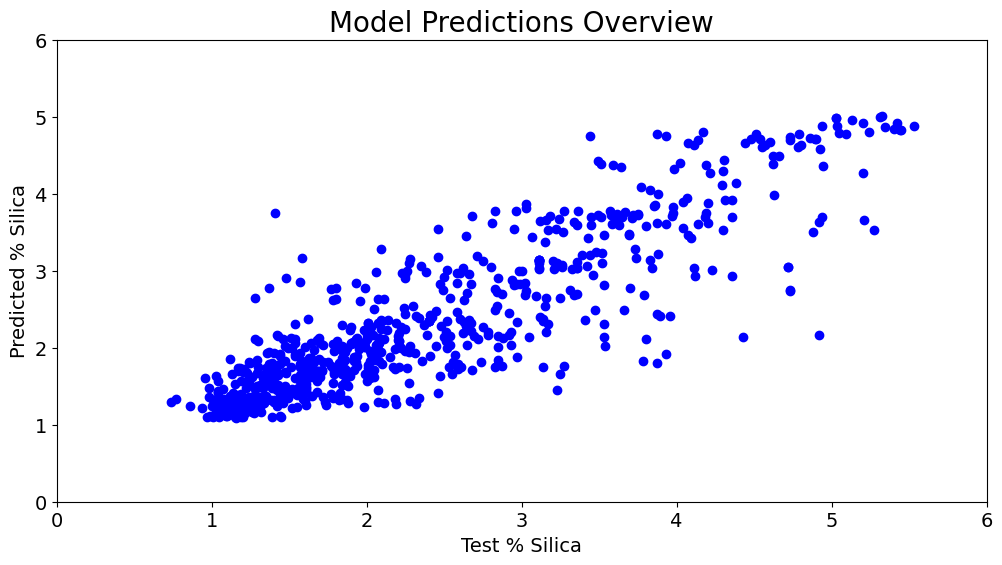

In [105]:
# Plot Settings
ncols, nrows = 1, 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
fig.subplots_adjust(hspace=.5, wspace=.35)
ax.set_title("Model Predictions Overview", fontsize=20)

ax.scatter(y_test, y_pred, color='b')
# Plot settings
ax.set_xlabel('Test % Silica', fontsize=14)
ax.set_ylabel('Predicted % Silica', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,6)
ax.set_ylim(0,6)
plt.show()

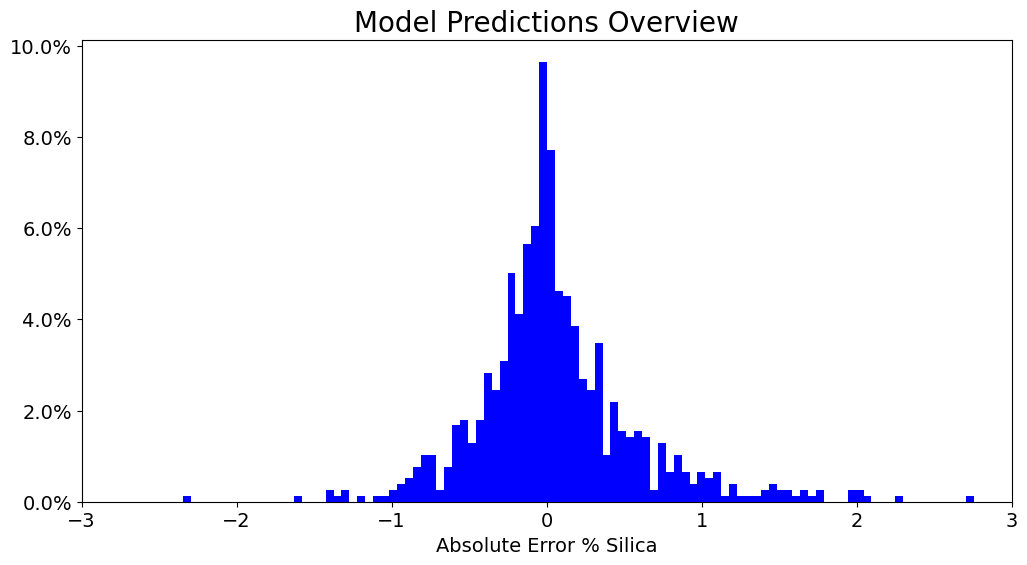

In [122]:
# Plot Settings
ncols, nrows = 1, 1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
fig.subplots_adjust(hspace=.5, wspace=.35)
hist = y_test-y_pred
ax.set_title("Model Predictions Overview", fontsize=20)
n, bins, patches = ax.hist(hist, weights=np.ones(len(hist)) / len(hist),
                           bins=100,  color='b', alpha=1)
ax.set_xlabel("Absolute Error % Silica", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-3,3)
plt.show()

<Axes: >

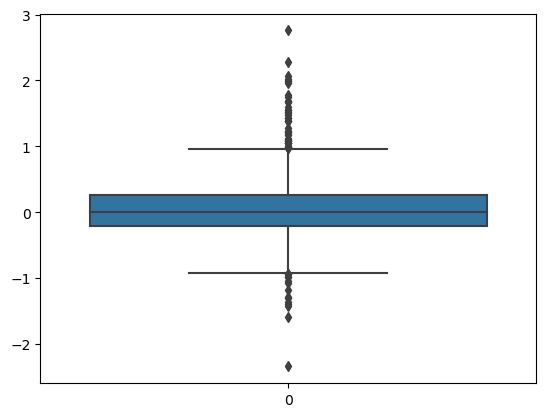

In [107]:
local_path = wandb.use_artifact("ts.csv:latest").file()
ts = pd.read_csv(local_path, decimal=",",parse_dates=["date"], index_col="date").dropna()
ts = ts.apply(pd.to_numeric)

In [133]:
ts.head()

,% Silica Concentrate_lag_-180,% Silica Concentrate_lag_-360,% Silica Concentrate_lag_-540,% Silica Concentrate_lag_-720,% Iron Concentrate_lag_-180,% Iron Concentrate_lag_-360,% Iron Concentrate_lag_-540,% Iron Concentrate_lag_-720,% Iron Feed,% Silica Feed,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,Predictions
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01 00:00:00,3.11,3.11,3.11,3.11,64.03,64.03,64.03,64.03,59.72,9.22,...,249.310,249.082,807.178,799.417,799.614,461.455,476.486,421.792,449.983,3.125496
2017-04-01 00:00:20,3.11,3.11,3.11,3.11,64.03,64.03,64.03,64.03,59.72,9.22,...,249.789,251.697,796.664,801.230,809.079,472.089,444.256,438.702,430.522,3.137796
2017-04-01 00:00:40,3.11,3.11,3.11,3.11,64.03,64.03,64.03,64.03,59.72,9.22,...,249.168,249.989,802.674,780.025,796.883,475.400,449.314,424.064,432.860,3.137796
2017-04-01 00:01:00,3.11,3.11,3.11,3.11,64.03,64.03,64.03,64.03,59.72,9.22,...,249.083,250.518,805.994,777.026,793.741,472.197,449.925,444.297,435.181,3.137796
2017-04-01 00:01:20,3.11,3.11,3.11,3.11,64.03,64.03,64.03,64.03,59.72,9.22,...,249.287,252.257,807.858,783.881,795.499,465.469,448.131,483.404,437.493,3.132996


In [136]:
bins = [0, 6, 12, 18, 24]
labels = ['Shift A', 'Shift B', 'Shift C', 'Shift D']
ts['Shift'] = pd.cut(ts.index.hour, bins, labels=labels, right=False)

# Bining Production Levels
ts['Production Level'] = np.nan
p_max = np.max(df['Ore Pulp Flow'])
bins = [0, 380, 410, p_max]
labels = ['Low Production', 'Mid Production', 'High Production']
ts['Production Level'] = pd.cut(ts['Ore Pulp Flow'], bins=bins, labels=labels)
logger.info('Finished Basic Feature Engineering.')

2023-04-26 17:50:20,859 Finished Basic Feature Engineering.


In [132]:
ts['Predictions'] = sk_pipe.predict(ts.drop('% Silica Concentrate_lag_-180', axis=1))

In [134]:
ts['Errors'] = ts['Predictions']-ts['% Silica Concentrate_lag_-180']

<Axes: xlabel='Errors', ylabel='Shift'>

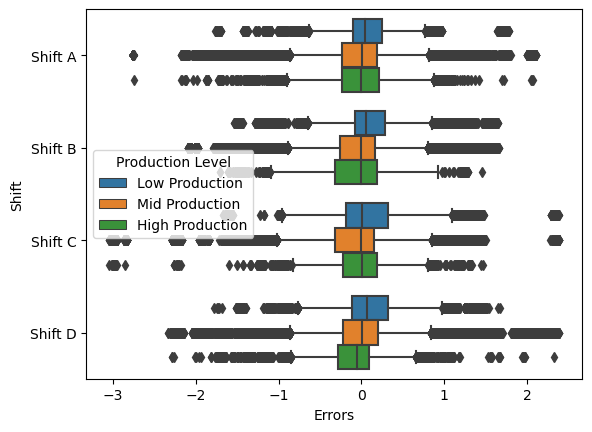

In [138]:
sns.boxplot(data=ts, x="Errors", y='Shift', hue='Production Level')

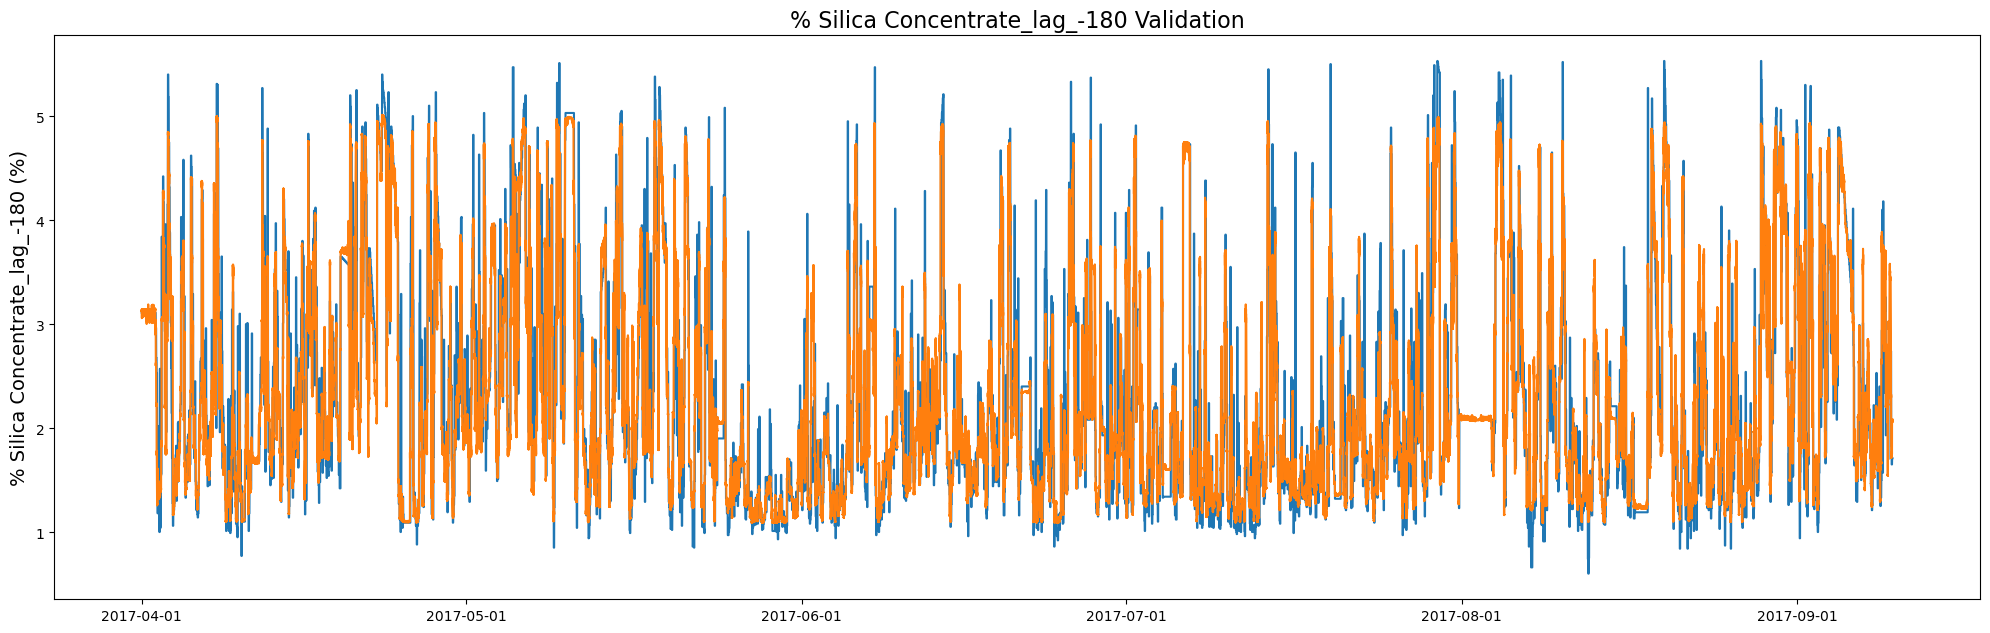

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts[['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipykernel_11080/3609652045.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax.plot(ts['2017-07'][['% Silica Concentrate_lag_-180','Predictions']])


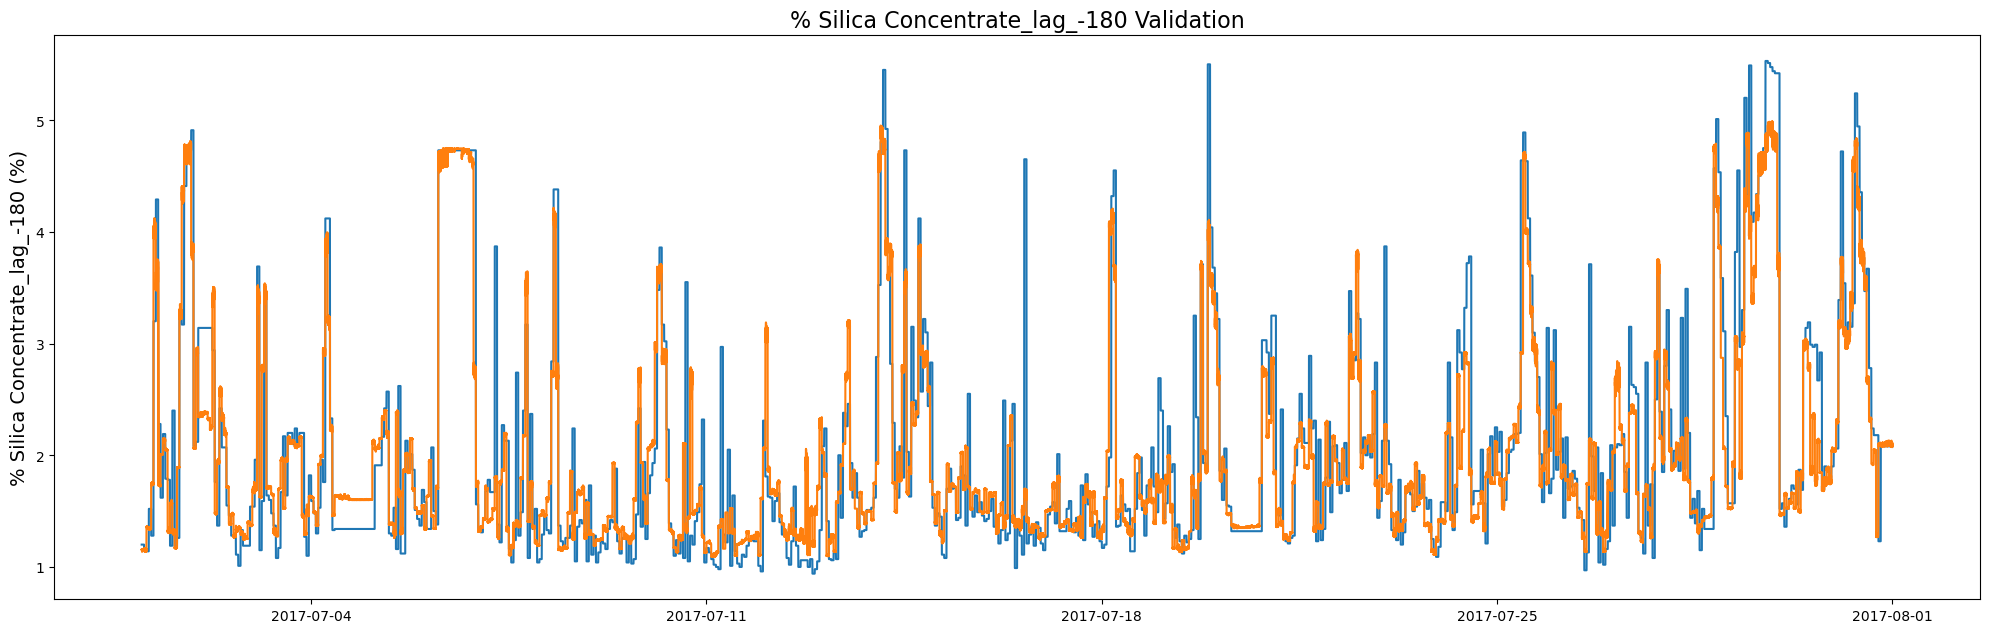

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-07'][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

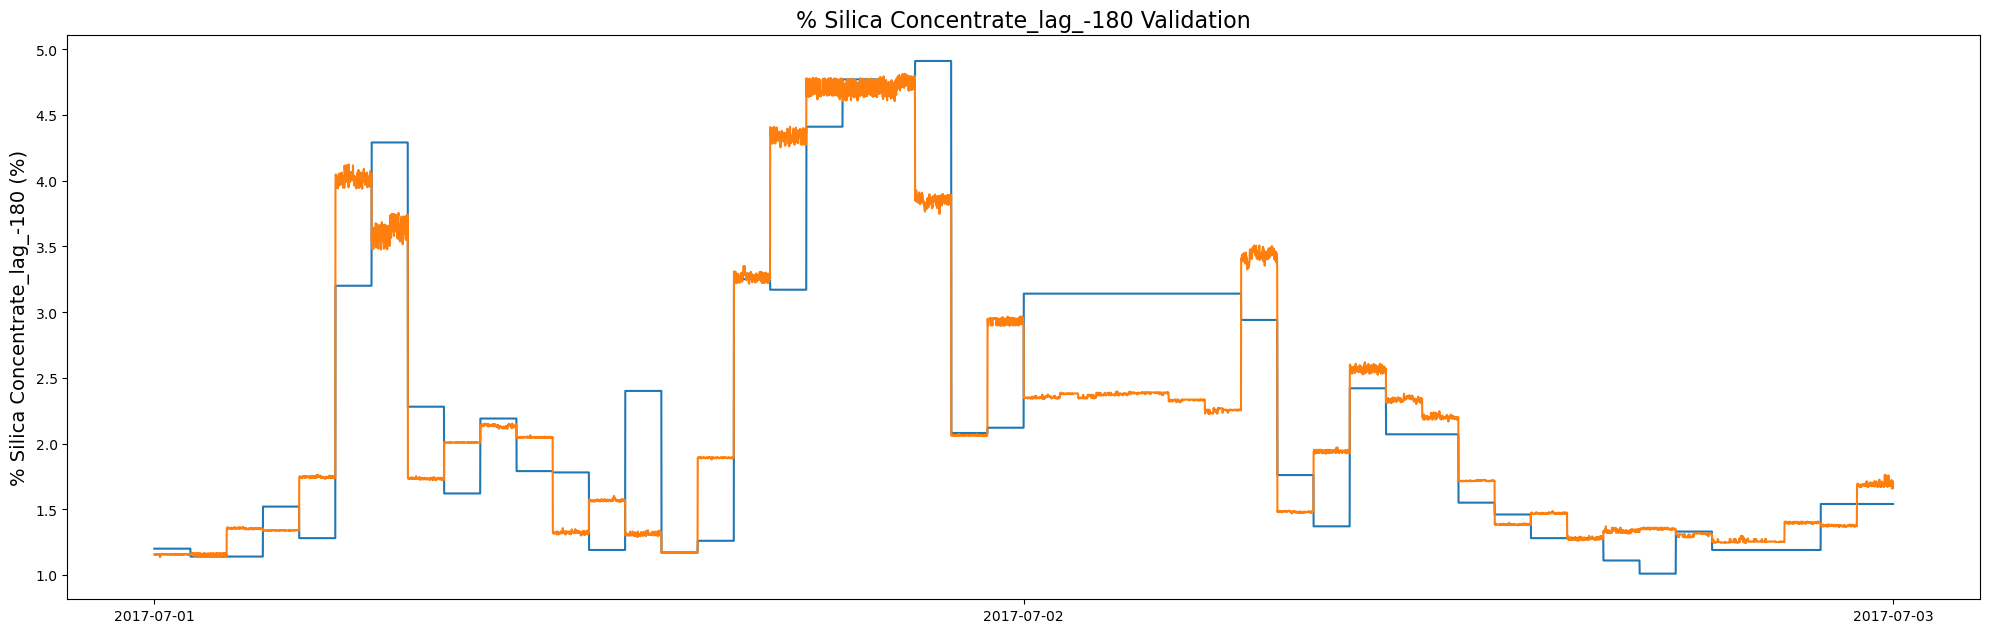

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-07-01':'2017-07-02'][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

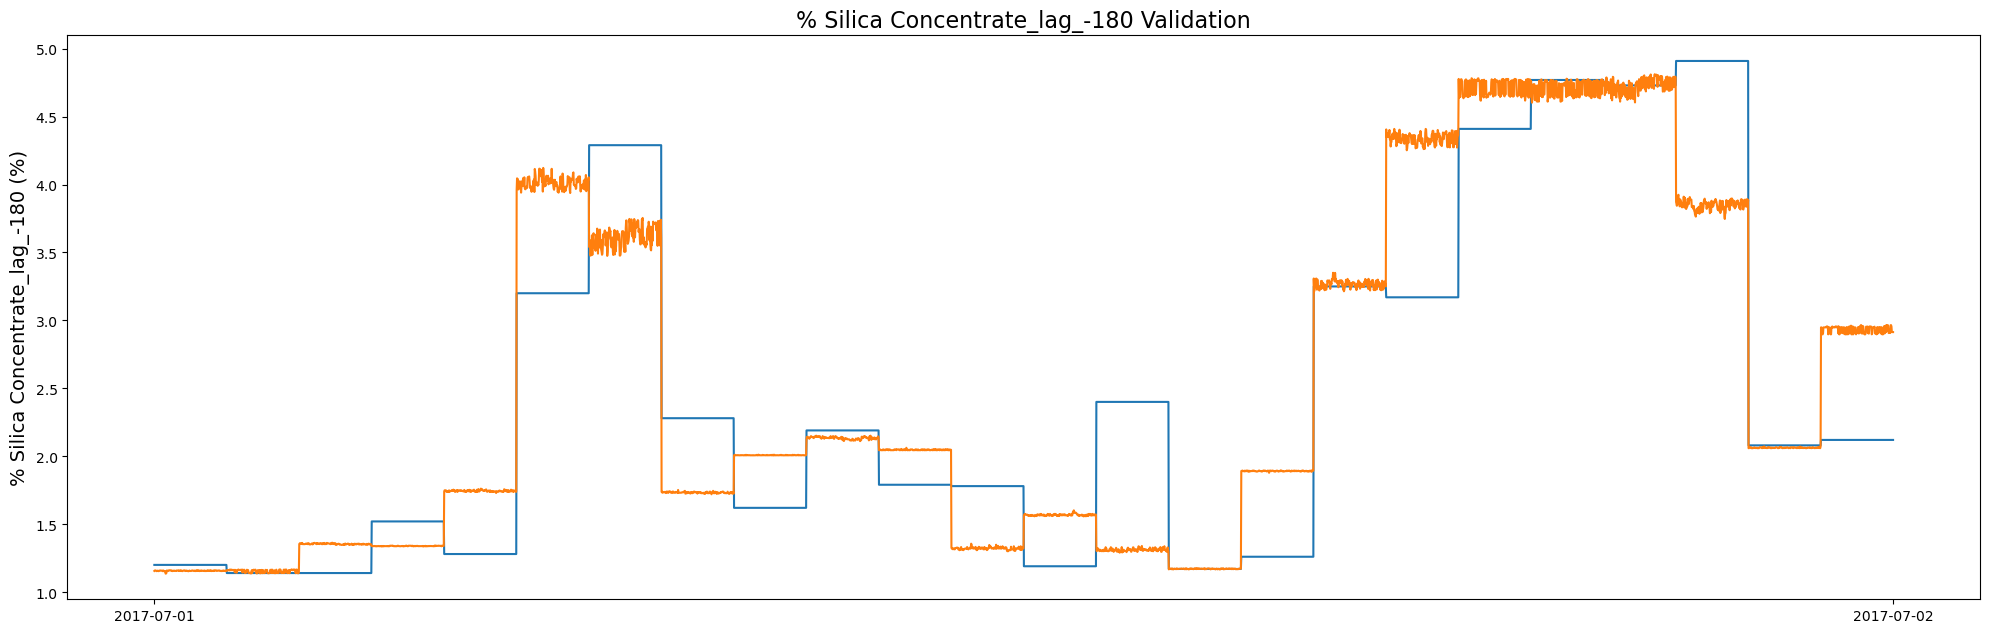

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-07-01':'2017-07-01'][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

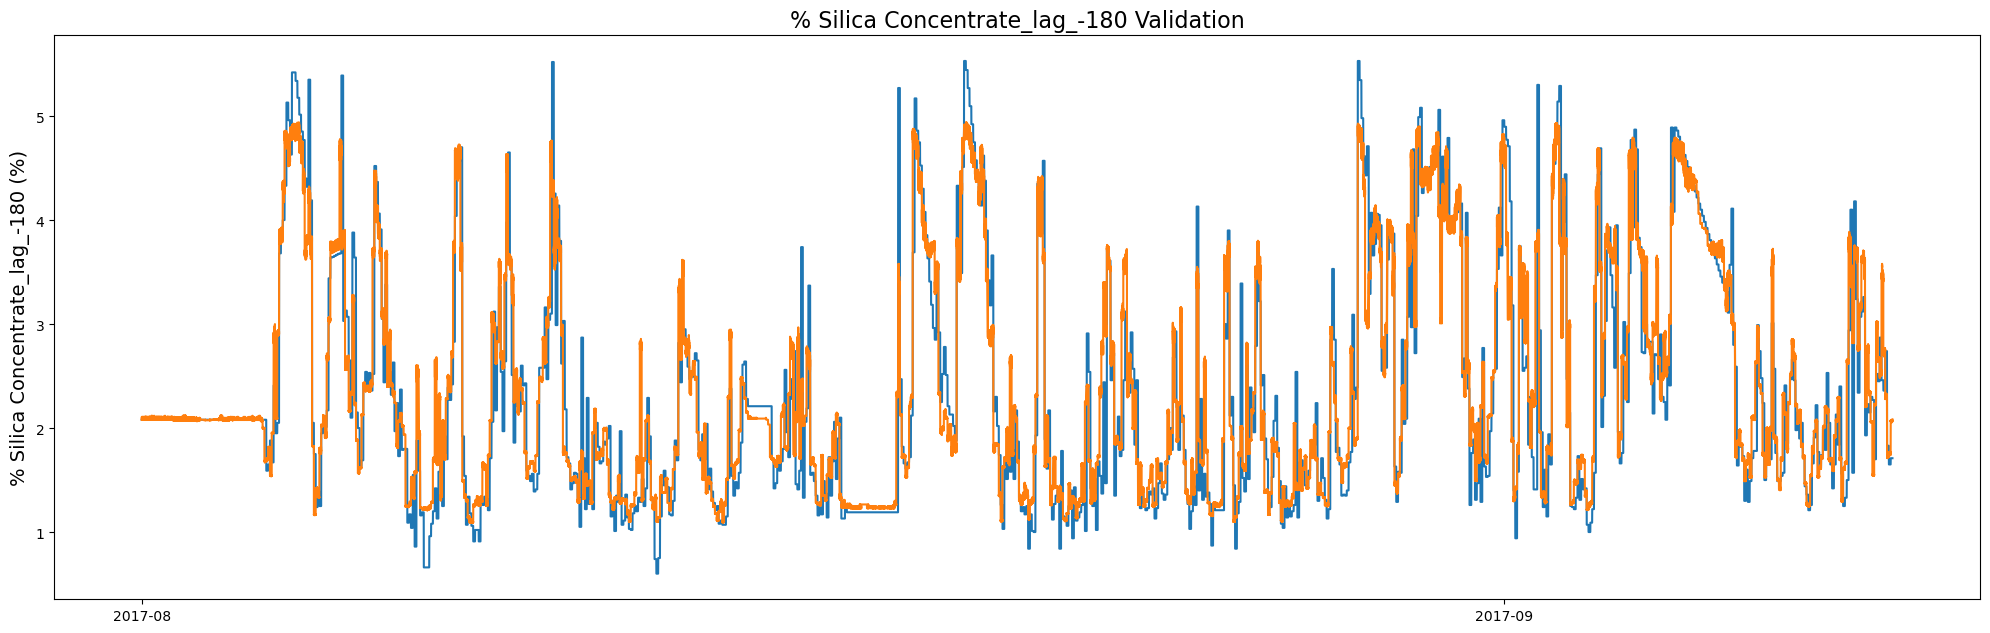

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-08-01':][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

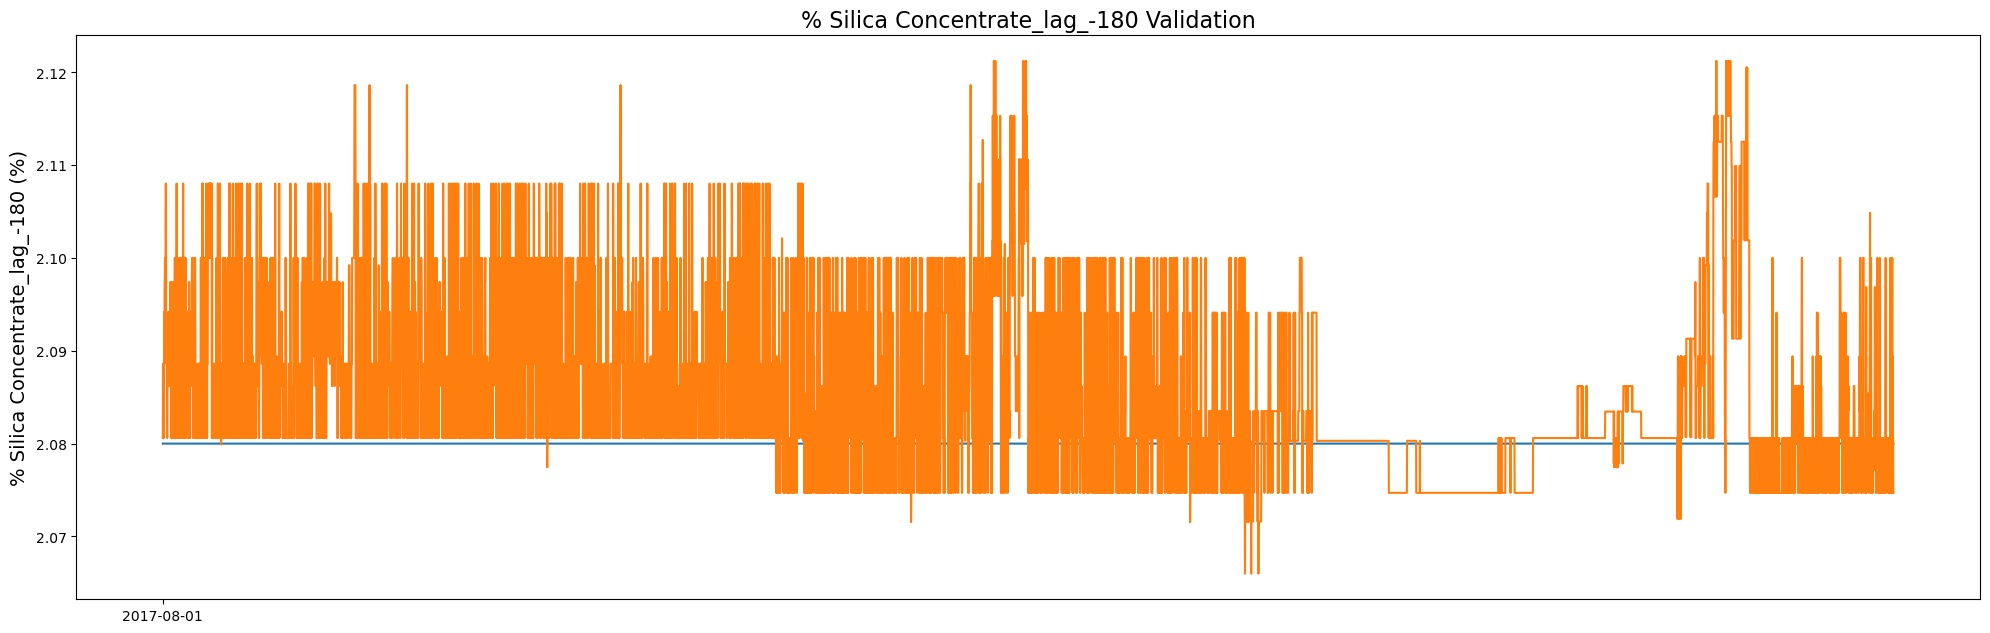

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-08-01':'2017-08-02'][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

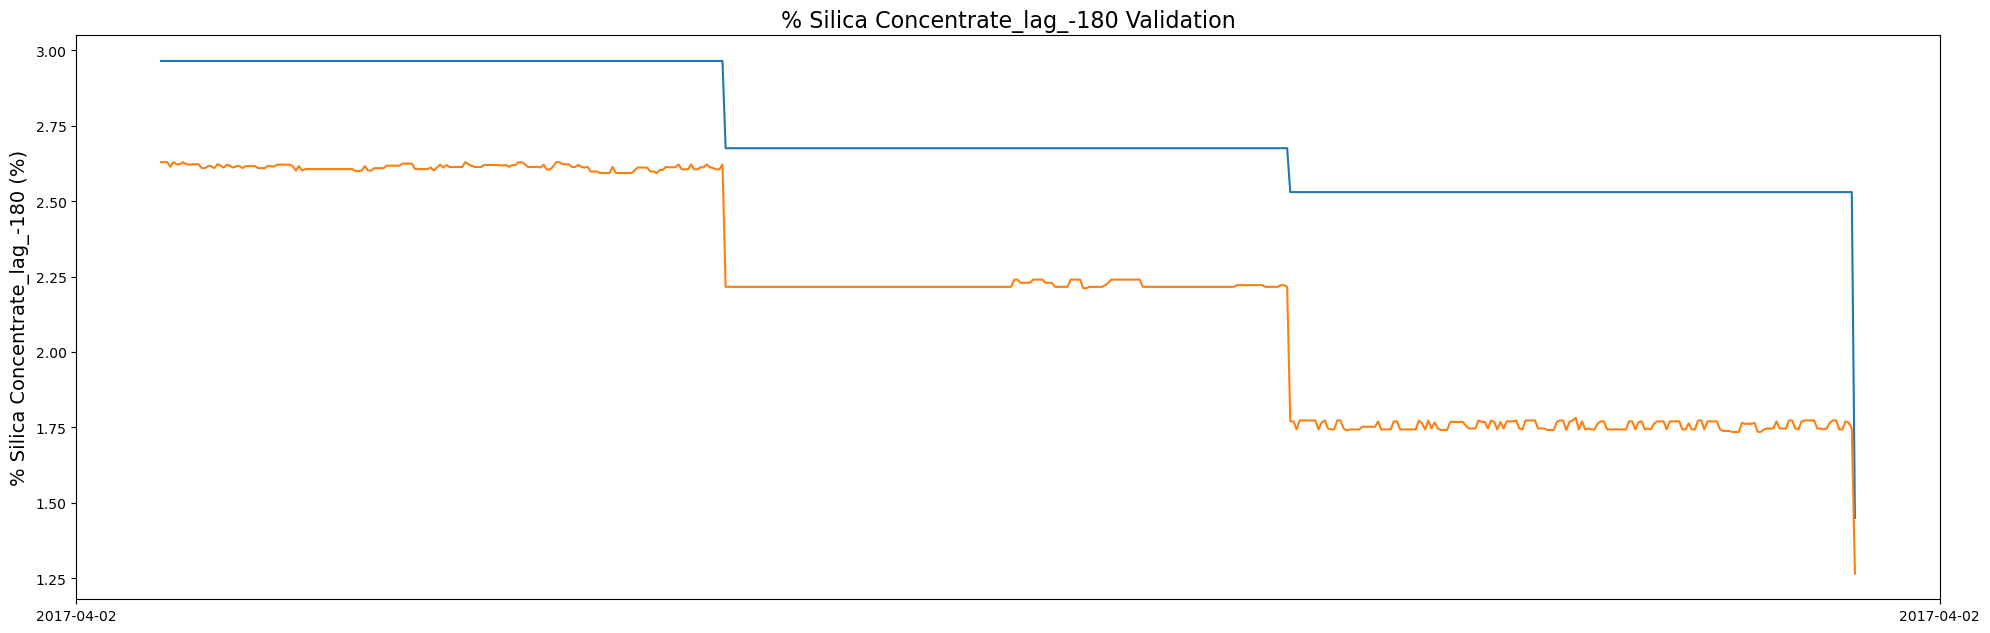

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
col = '% Silica Concentrate_lag_-180'
ax.plot(ts['2017-04-02 07:00:00':'2017-04-02 10:00:00'][['% Silica Concentrate_lag_-180','Predictions']])
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
ax.set_title(f'{col} Validation', fontdict={'fontsize':16})
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def hist_line_plot(df: pd.DataFrame, target_var: str, y_label: str = '', xaxis_formater: str = 'day', color_dict: dict=None, resample: str = '1d', bins: int = 150, subplot_position: list = [0.65, 0.6, .2, .2]):

    VAR = target_var
    if color_dict:
        COLORS = color_dict
    else:
        COLORS = {target_var : '#7A542E'}

    # Plot Settings
    ncols, nrows = 1, 1
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
    fig.subplots_adjust(hspace=.5, wspace=.35)

    hist = df[target_var].values

    # Ore Pulp Flow - Subgraph 01
    a = plt.axes(subplot_position)
    ax2 = plt.gca()
    ax2.set_title(target_var)
    ax2.plot(df[target_var], color=COLORS[VAR], alpha=.2)
    ax2.plot(df[target_var].resample(resample).mean(), color=COLORS[VAR], label=target_var)
    if xaxis_formater == 'month':
        ax2.xaxis.set_major_locator(mdates.MonthLocator([5,7,9]))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if xaxis_formater == 'day':
        ax2.xaxis.set_major_locator(mdates.HourLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.set_ylabel(f"{y_label} ({UM[target_var]})", fontsize=8)
    ax2.tick_params(axis='both', labelsize=8)


    # Plot settings
    ax.set_title(target_var, fontsize=20)
    n, bins, patches = ax.hist(hist, weights=np.ones(len(hist)) / len(hist),
                               bins=bins,  color=COLORS[VAR], alpha=1, label=target_var)
    ax.set_xlabel(f"{y_label} ({UM[target_var]})", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.legend(loc='upper left', fontsize=12)

    # plt.savefig(os.path.join(report_plots, 'ng_flow_power_plant_details'),dpi=300)
    plt.show()
    
def binned_hist_plot(df: pd.DataFrame, target_var: str, split_var: str, y_label: str = '', bins: int = 150, color_list: list = None):
    
    VAR = target_var
    COLORS = {target_var : '#7A542E'}
    
    if color_list is None:
        color_list = ['steelblue'] * len(df[split_var].unique().tolist())
    
    # Plot Settings
    ncols, nrows = 1, 1
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
    fig.subplots_adjust(hspace=.5, wspace=.35)

    for split_value, color in zip(df[split_var].unique().tolist(), color_list):
        hist = df.loc[df[split_var]==split_value][target_var].values
         
        ax.set_title(target_var, fontsize=20)
        n, bins, patches = ax.hist(hist, weights=np.ones(len(hist)) / len(hist),
                                   bins=bins,  color=color, alpha=1, label=f'{target_var}\n{split_var} = {split_value}')
        
    
    # Plot settings
    ax.set_xlabel(f"{y_label} ({UM[target_var]})", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.legend(loc='upper left', fontsize=12)
    
    plt.show()
    
def scatter_plot(df: pd.DataFrame, var1: str, var2: str, x_label: str = '', y_label: str = '', title: str = None, color:str =  '#7A542E', legend:bool = False):

    # Plot Settings
    ncols, nrows = 1, 1
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
    fig.subplots_adjust(hspace=.5, wspace=.35)
    ax.set_title(title, fontsize=20)

    ax.scatter(df[var1], df[var2], color=color, label=f'{var1} x {var2}')
    # Plot settings
    ax.set_xlabel(f"{x_label} ({UM[var1]})", fontsize=14)
    ax.set_ylabel(f"{y_label} ({UM[var2]})", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    if legend:
        ax.legend(loc='best', fontsize=12)
    plt.show()
    
def discretized_scatter_plot(df: pd.DataFrame, var1: str, var2: str, split_var: str, x_label: str = '', y_label: str = '', title: str = None, color_list:list =['#7A542E'], marker_list: list = ['o'], legend:bool = False):
    
    # Plot Settings
    ncols, nrows = 1, 1
    split_values = df[split_var].unique().tolist()
    if len(color_list) == 1:
        color_list = color_list[0] * len(split_values)
        
    color_dict = dict(zip(split_values, color_list))
        
    if len(marker_list) == 1:
        marker_list = marker_list[0] * len(split_values)
    
    marker_dict = dict(zip(split_values, marker_list))
        
    custom_legend=[]
    for split_value in split_values:
        custom_legend.append(Line2D([0], [0], color=color_dict[split_value], lw=4))

    df['COLOR']  = df[split_var].map(color_dict)
    df['MARKER'] = df[split_var].map(marker_dict)
        
    
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,6))
    fig.subplots_adjust(hspace=.5, wspace=.35)
    ax.set_title(title, fontsize=20)
    
    ax.scatter(df[var1], df[var2], c=df['COLOR'], label=f'{var1} x {var2}')
    # Plot settings
    ax.set_xlabel(f"{x_label} ({UM[var1]})", fontsize=14)
    ax.set_ylabel(f"{y_label} ({UM[var2]})", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    if legend:
        ax.legend(custom_legend, split_values, loc='best')
    plt.show()
    
def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation. 
    Shifted data (y) filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    x, y : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return x.corr(y.shift(lag))

def adf_test(df, TARGET: str = ''):
    result = adfuller(df.values)
    print(f'ADF Test: {TARGET}')
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        

def plot_ccf_manual(target, exog, nlags=10):
    """PLot CCF using manual calculations"""
    lags = []
    ccfs = []
    for i in np.arange(0,nlags+1):
        lags.append(i)
        ccfs.append(crosscorr(target, exog, lag=i))

    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation (Manual): {target.name} & {exog.name}")
    
def plot_ccf_sm(target, exog, unbiased=False, nlags=10, save_fig=False, name=''):
    """Plot CCF using Statsmodels"""
    ccfs = ccf(target, exog, unbiased=False)[:nlags+1]
    lags = np.arange(len(ccfs))[:nlags+1]
    _ = plt.stem(lags, ccfs, use_line_collection=True)
    _ = plt.title(f"Cross Correlation: {target.name} & {exog.name}")
    _ = plt.ylabel('Cross Correlation Value')
    _ = plt.xlabel('N lags')
    
    if save_fig:
        plt.savefig(os.path.join(save_plots_folder, f'cross-corr-plot-bfg-time-series-data-{name[0:7]}.png'), dpi=300, facecolor='white')
    plt.show()
    return

In [ ]:
df.columns

In [ ]:
hist_line_plot(df=df,
               target_var='% Iron Concentrate',
               y_label='Iron Concentration',
               xaxis_formater='month',
               resample='1D',
               bins=90)

In [ ]:
hist_line_plot(df=df,
               target_var='% Silica Concentrate',
               y_label='Silica Concentration',
               xaxis_formater='month',
               resample='1D',
               bins=90)

In [ ]:
hist_line_plot(df=df,
               target_var='Ore Pulp Flow',
               y_label='Production',
               xaxis_formater='month',
               resample='1D',
               bins=90)

In [ ]:
hist_line_plot(df=df,
               target_var='% Iron Feed',
               y_label='Iron Feed',
               xaxis_formater='month',
               resample='1D',
               bins=30)

In [ ]:
hist_line_plot(df=df,
               target_var='% Silica Feed',
               y_label='Silica Feed',
               xaxis_formater='month',
               resample='1D',
               bins=30)

In [ ]:
hist_line_plot(df=df,
               target_var='Starch Flow',
               y_label='Starch Flow',
               xaxis_formater='month',
               resample='1D',
               bins=100,
               subplot_position=[0.68, 0.6, .2, .2])

In [ ]:
hist_line_plot(df=df,
               target_var='Amina Flow',
               y_label='Amina Flow',
               xaxis_formater='month',
               resample='1D',
               bins=100,
              subplot_position=[0.69, 0.63, .2, .2])

In [ ]:
binned_hist_plot(df=df, target_var='% Iron Concentrate', split_var='Production Level', color_list=['#A27035', '#242331', '#DDCA7D'], bins=90)

In [ ]:
binned_hist_plot(df=df, target_var='% Iron Concentrate', split_var='Shift', color_list=['#A27035', '#242331', '#DDCA7D', '#A499BE'], bins=90)

In [ ]:
binned_hist_plot(df=df, target_var='Ore Pulp Flow', split_var='Shift', color_list=['#A27035', '#242331', '#DDCA7D', '#A499BE'], bins=150)

In [ ]:
scatter_plot(df=df, var1='% Iron Concentrate', var2='% Silica Concentrate', x_label='Iron Concentrate', y_label='Silica Concentrate', title='Iron and Silica Concentration')

In [ ]:
scatter_plot(df=df, var2='% Iron Concentrate', var1='% Iron Feed', x_label='Iron Feed', y_label='Iron Concentrate', title='Iron Feed and Iron Concentration')

In [ ]:
df_ = deepcopy(df)
df_['% Iron Concentrate'] = df['% Iron Concentrate'].shift(180)
scatter_plot(df=df_, var2='% Iron Concentrate', var1='% Iron Feed', x_label='% Iron Feed', y_label='% Iron Concentrate', title='Iron Feed and Iron Concentration')
del df_

In [ ]:
df_ = deepcopy(df)
df_['% Iron Concentrate'] = df['% Iron Concentrate'].shift(360)
scatter_plot(df=df_, var2='% Iron Concentrate', var1='% Iron Feed', x_label='% Iron Feed', y_label='% Iron Concentrate', title='Iron Feed and Iron Concentration')
del df_

In [ ]:
for idx, col in enumerate(df.columns.tolist()):
    try:
        if idx >=2:
            df_ = deepcopy(df.resample('1H').mean())
            scatter_plot(df=df_, var2='% Silica Concentrate', var1=col, x_label=col, y_label='% Silica Concentrate', title=f'{col} and % Silica Concentrate')
            del df_
        else:
            scatter_plot(df=df, var2='% Silica Concentrate', var1=col, x_label=col, y_label='% Silica Concentrate', title=f'{col} and % Silica Concentrate')
    except:
        continue

In [ ]:
resample_dict = dict(zip(df.select_dtypes(include='number').columns.tolist(), ['mean']*(len(df)-2)))
resample_dict.update(zip(df.select_dtypes(exclude='number').columns.tolist(), ['first','first']))
grouped_df = df.groupby([pd.Grouper(freq='h')]).agg(resample_dict)
for idx, col in enumerate(df.columns.tolist()):
    discretized_scatter_plot(df=grouped_df, var1=col, var2='% Silica Concentrate', split_var='Production Level', legend=True, x_label=col, y_label='% Silica Concentrate', title=f'{col} and % Silica Concentrate', color_list=['#A27035', '#242331', '#DDCA7D'])

In [ ]:
resample_dict = dict(zip(df.select_dtypes(include='number').columns.tolist(), ['mean']*(len(df)-2)))
resample_dict.update(zip(df.select_dtypes(exclude='number').columns.tolist(), ['first','first']))
grouped_df = df.groupby([pd.Grouper(freq='h')]).agg(resample_dict)
for idx, col in enumerate(df.columns.tolist()):
    discretized_scatter_plot(df=grouped_df, var1=col, var2='% Silica Concentrate', split_var='Shift', legend=True, x_label=col, y_label='% Silica Concentrate', title=f'{col} and % Silica Concentrate', color_list=['#A27035', '#242331', '#DDCA7D', '#A499BE'])

In [ ]:
resample_dict = dict(zip(df.select_dtypes(include='number').columns.tolist(), ['mean']*(len(df)-2)))
resample_dict.update(zip(df.select_dtypes(exclude='number').columns.tolist(), ['first','first']))
grouped_df = df.groupby([pd.Grouper(freq='h')]).agg(resample_dict)
for idx, col1 in enumerate(df.columns.tolist()):
    for idx, col2 in enumerate(df.columns.tolist()):
        if col1 == col2:
            continue
        else:
            discretized_scatter_plot(df=grouped_df, var1=col1, var2=col2, split_var='Production Level', legend=True, x_label=col1, y_label=col2, title=f'{col1} and {col2}', color_list=['#A27035', '#242331', '#DDCA7D'])
            discretized_scatter_plot(df=grouped_df, var1=col1, var2=col2, split_var='Shift', legend=True, x_label=col1, y_label=col2, title=f'{col1} and {col2}', color_list=['#A27035', '#242331', '#DDCA7D', '#A499BE'])

In [ ]:
import seaborn as sns
corr_map = df.select_dtypes(include='number').resample('1h').mean()

fig, ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('white')
fig.set_facecolor('white')
plt.title('Correlation Map', fontsize=15)
matrix = np.triu(corr_map.corr())
sns.heatmap(corr_map.corr(), annot=True, mask=matrix, vmin=-1, vmax=1, center= 0, ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Plot autocorrelation
plt.rc("figure", figsize=(18,5))
plot_acf(df['% Silica Concentrate'].resample('1H').mean(), lags=int(180*2))
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
result = seasonal_decompose(df['% Silica Concentrate'].resample('1H').mean(), model='additive')
result.plot()
plt.show()

In [ ]:
from sktime.transformations.series.summarize import WindowSummarizer

kwargs = {
    "lag_feature": {
        "lag": [0, 180, 360, 540, 720],
    }
}
transformer = WindowSummarizer(**kwargs, target_cols=['% Silica Concentrate','% Iron Concentrate'])
df_transformed = transformer.fit_transform(df)
df_transformed.head(2)

In [ ]:
cols_heatmap = df_transformed.filter(regex='Silica Concentrate').columns.tolist()

fig, ax = plt.subplots(figsize=(20,8))
fig.patch.set_facecolor('white')
fig.set_facecolor('white')
plt.title('Correlation Map - % Silica Concentrate', fontsize=15)
sns.heatmap(df_transformed.select_dtypes(include='number').resample('1h').mean().reset_index(drop=True).corr()[cols_heatmap].T, annot=True,  vmin=-1, vmax=1, center= 0, ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
y_transformed.filter(regex='Silica Concentrate').columns.tolist()

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
fig.patch.set_facecolor('white')
fig.set_facecolor('white')
plt.title('Correlation Map - % Silica Concentrate Lag 1 Hour', fontsize=15)
sns.heatmap(y_transformed.select_dtypes(include='number').resample('1h').mean().reset_index(drop=True).corr()[['% Silica Concentrate_lag_180']].T, annot=True,  vmin=-1, vmax=1, center= 0, ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
fig.patch.set_facecolor('white')
fig.set_facecolor('white')
plt.title('Correlation Map - % Silica Concentrate Lag 2 Hours', fontsize=15)
sns.heatmap(y_transformed.select_dtypes(include='number').resample('1h').mean().reset_index(drop=True).corr()[['% Silica Concentrate_lag_360']].T, annot=True,  vmin=-1, vmax=1, center= 0, ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
for col in df.select_dtypes(include='number').columns.tolist():
    plot_ccf_sm(df['% Silica Concentrate'].dropna(), df[col].dropna(), nlags=int(50e2), save_fig=False)

In [ ]:
df['Production Level'] = np.nan
p_max = np.max(df['Ore Pulp Flow'])
bins = [0, 380, 410, p_max]
labels = ['Low', 'Mid', 'High']
df['Production Level'] = pd.cut(df['Ore Pulp Flow'], bins=bins, labels=labels)

In [ ]:
df['Ore Pulp Flow'].describe()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for idx, col in enumerate(df.columns[0:3]):
    try:
        ax = plt.subplot(1,2, (idx+1))
        ax.plot(df[col])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        
    except:
        pass
    
plt.suptitle('Input Materials During 2017\nQuality Measurements of Iron Pulp before fed into Flotation Plant', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for idx, col in enumerate(df.columns[0:3]):
    try:
        ax = plt.subplot(1,2, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-31'][col])
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        
    except:
        pass
    
plt.suptitle('Input Materials - Zoom Jul/2017\nQuality Measurements of Iron Pulp before fed into Flotation Plant', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, col in enumerate(df.columns[2:7]):
    try:
        ax = plt.subplot(2,3, (idx+1))
        ax.plot(df[col], label='Signal')
        ax.plot(df[col].rolling(int(3*60*24)).mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During 2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, col in enumerate(df.columns[2:7]):
    try:
        ax = plt.subplot(2,3, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-31'][col], label='Signal')
        ax.plot(df['2017-07-01':'2017-07-31'][col].rolling(int(3*60*24)).mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, col in enumerate(df.columns[2:7]):
    try:
        ax = plt.subplot(2,3, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-01'][col], label='Signal')
        ax.plot(df['2017-07-01':'2017-07-01'][col].rolling(int(3*60)).mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{col} ({UM[col]})", fontdict={'fontsize':14})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30, 15))

for idx, col in enumerate([
        'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']
        ):
    try:
        ax = plt.subplot(5,3, (idx+1))
        ax.plot(df[col], label='Signal')
        ax.plot(df[col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(f"{UM[col]}", fontdict={'fontsize':12})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[-1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During 2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30, 15))

for idx, col in enumerate([
        'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']
        ):
    try:
        ax = plt.subplot(5,3, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-31'][col], label='Signal')
        ax.plot(df['2017-07-01':'2017-07-31'][col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{UM[col]}", fontdict={'fontsize':12})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[-1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(30, 15))

for idx, col in enumerate([
        'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']
        ):
    try:
        ax = plt.subplot(5,3, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-01'][col], label='Signal')
        ax.plot(df['2017-07-01':'2017-07-01'][col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{UM[col]}", fontdict={'fontsize':12})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        ax.legend(loc='upper left', fontsize=12)
    except:
        pass
fig.delaxes(axes[-1][-1])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
cols =['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']

for idx, sub in enumerate(["0"+str(i) for i in range(1,8)]):
    cols_ = [s for s in cols if sub in s]
    color_dict = dict(zip(cols_,['blue','orange']))
    alpha_dict = dict(zip(cols_,[.3,1]))
    
    
    for idx_, col in enumerate(cols_):
        
        ax = plt.subplot(3,3, (idx+1))
        ax.set_title(f'{cols_[0]} & {cols_[1]}', fontdict={'fontsize':16})
        ax.plot(df['2017-07-01':'2017-07-31'][col], label='Signal', color='blue', alpha=.3)
        ax.plot(df['2017-07-01':'2017-07-31'][col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    custom_legend=[]
    for col in cols_:
        custom_legend.append(Line2D([0], [0], color=color_dict[col], alpha=alpha_dict[col], lw=2))
    ax.legend(custom_legend, ['Signal','Filtered'], loc='upper left', fontsize=12)
fig.delaxes(axes[-1][-1])
fig.delaxes(axes[-1][-2])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
cols =['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']

for idx, sub in enumerate(["0"+str(i) for i in range(1,8)]):
    cols_ = [s for s in cols if sub in s]
    color_dict = dict(zip(cols_,['blue','orange']))
    alpha_dict = dict(zip(cols_,[.3,1]))
    
    
    for idx_, col in enumerate(cols_):
        
        ax = plt.subplot(3,3, (idx+1))
        ax.set_title(f'{cols_[0]} & {cols_[1]}', fontdict={'fontsize':16})
        ax.plot(df['2017-07-22':'2017-07-26'][col], label='Signal', color='blue', alpha=.3)
        ax.plot(df['2017-07-22':'2017-07-26'][col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    custom_legend=[]
    for col in cols_:
        custom_legend.append(Line2D([0], [0], color=color_dict[col], alpha=alpha_dict[col], lw=2))
    ax.legend(custom_legend, ['Signal','Filtered'], loc='upper left', fontsize=12)
fig.delaxes(axes[-1][-1])
fig.delaxes(axes[-1][-2])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
cols =['Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level']

for idx, sub in enumerate(["0"+str(i) for i in range(1,8)]):
    cols_ = [s for s in cols if sub in s]
    color_dict = dict(zip(cols_,['blue','orange']))
    alpha_dict = dict(zip(cols_,[.3,1]))
    
    
    for idx_, col in enumerate(cols_):
        
        ax = plt.subplot(3,3, (idx+1))
        ax.set_title(f'{cols_[0]} & {cols_[1]}', fontdict={'fontsize':16})
        ax.plot(df['2017-07-22':'2017-07-24'][col], label='Signal', color='blue', alpha=.3)
        ax.plot(df['2017-07-22':'2017-07-24'][col].resample('1h').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    custom_legend=[]
    for col in cols_:
        custom_legend.append(Line2D([0], [0], color=color_dict[col], alpha=alpha_dict[col], lw=2))
    ax.legend(custom_legend, ['Signal','Filtered'], loc='upper left', fontsize=12)
fig.delaxes(axes[-1][-1])
fig.delaxes(axes[-1][-2])
plt.suptitle('Important Features that Impacts Ore Quality During Jul/2017\n Measurements of Context Features', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for idx, col in enumerate(['% Iron Concentrate', '% Silica Concentrate']):
    try:
        ax = plt.subplot(1,2, (idx+1))
        ax.plot(df[col], label='Signal')
        ax.plot(df[col].resample('1d').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_ylabel(f"{UM[col]}", fontdict={'fontsize':12})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        
    except:
        pass
    
plt.suptitle('Target Features During 2017\nQuality Measurements of Iron Pulp before fed into Flotation Plant', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for idx, col in enumerate(['% Iron Concentrate', '% Silica Concentrate']):
    try:
        ax = plt.subplot(1,2, (idx+1))
        ax.plot(df['2017-07-01':'2017-07-03'][col], label='Signal')
        # ax.plot(df['2017-07-01':'2017-07-31'][col].resample('1d').mean(), color='orange', label='Filtered')
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.set_ylabel(f"{UM[col]}", fontdict={'fontsize':12})
        ax.set_title(f'{col}', fontdict={'fontsize':16})
        
    except:
        pass
    
plt.suptitle('Target Features During Jul/2017\nQuality Measurements of Iron Pulp before fed into Flotation Plant', fontsize=22)
plt.tight_layout(pad=1.08, h_pad=.8, w_pad=.5, rect=[0, 0.03, 1, 0.95])
plt.show()

## Feature Selection

In [ ]:
resample_dict = dict(zip(df_transformed.select_dtypes(include='number').columns.tolist(), ['mean']*(len(df_transformed)-2)))
resample_dict.update(zip(df_transformed.select_dtypes(exclude='number').columns.tolist(), ['first','first']))
tx_transformed = df_transformed.groupby([pd.Grouper(freq='h')]).agg(resample_dict).dropna()

In [ ]:
tx_transformed['% Silica Concentrate_lag_180'].values

In [ ]:
from xgboost import XGBRegressor, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

pipe = Pipeline([('scaler', StandardScaler()), ('importance', XGBRegressor(n_estimators=100))])

folds = 10

X = tx_transformed.select_dtypes(include='number').drop('% Silica Concentrate_lag_180', axis=1).values
y = tx_transformed['% Silica Concentrate_lag_180'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
cv = KFold(n_splits=10)

scores = cross_validate(pipe, X_train, y_train, n_jobs=-1, scoring=['neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'r2'], cv=cv, return_train_score=True, return_estimator=False)

# np.mean(scores*-1), np.std(scores*-1), np.size(scores)

In [ ]:
test_scores = []
features_importance_scores = []
features_importance_labels = []
for p in scores['estimator']:
    test_scores.append(p[1].score(X_test, y_test))
    features_importance_scores.append(p[1].feature_importances_)
    features_importance_labels.append(p[1].feature_importances_.argsort())

In [ ]:
feature_scores_dict = dict(zip([str(i) for i in list(features_importance_labels[0])], [[]]*len(features_importance_labels[0])))
for run, score in zip(features_importance_labels, features_importance_scores):
    for label, value in zip(run, score):
        feature_scores_dict[str(label)] = feature_scores_dict[str(label)] + [value]

In [ ]:
pipe.fit(X_train, y_train)
sorted_idx = pipe.steps[1][1].feature_importances_.argsort()

In [ ]:
pipe.score(X_test, y_test)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

ax.barh(tx_transformed.select_dtypes(include='number').columns[sorted_idx], pipe.steps[1][1].feature_importances_)
ax.set_title("Feature Importance\nPrediction Silica Concentrate at 1 Hour Lag - XGBoost Model", fontsize=18)
ax.set_xlabel('Gain Importance', fontsize=14)
plt.show()

In [ ]:
tx_transformed

In [ ]:
run.finish()